# Example: DC-DC converter


We consider a boost DC-DC converter which has been widely studied from the point of view of hybrid control, see for example in  [1, V.A],[2],[3].
This is a **safety problem** for a **switching system**.

![Boost DC-DC converter.](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/assets/dcdcboost.jpg?raw=true)

The state of the system is given by $x(t) = \begin{bmatrix} i_l(t) & v_c(t) \end{bmatrix}^\top$.
The switching system has two modes consisting in two-dimensional affine dynamics:
$$
\dot{x} = f_p(x) = A_p x + b_p,\quad p=1,2
$$
with
$$
A_1 = \begin{bmatrix} -\frac{r_l}{x_l} &0 \\ 0 & -\frac{1}{x_c}\frac{1}{r_0+r_c}  \end{bmatrix}, A_2= \begin{bmatrix} -\frac{1}{x_l}\left(r_l+\frac{r_0r_c}{r_0+r_c}\right) & -\frac{1}{x_l}\frac{r_0}{r_0+r_c}  \\ \frac{1}{x_c}\frac{r_0}{r_0+r_c}   & -\frac{1}{x_c}\frac{1}{r_0+r_c}  \end{bmatrix}, b = \begin{bmatrix} \frac{v_s}{x_l}\\0\end{bmatrix}.
$$
The goal is to design a controller to keep the state of the system in a safety region around the reference desired value, using as input only the switching
signal.


In order to study the concrete system and its symbolic abstraction in a unified framework, we will solve the problem
for the sampled system with a sampling time $\tau$.

The abstraction is based on a feedback refinment relation [4,V.2 Definition].
Basically, this is equivalent to an alternating simulation relationship with the additional constraint that the input of the
concrete and symbolic system preserving the relation must be identical.
This allows to easily determine the controller of the concrete system from the abstraction controller by simply adding a quantization step.

For the construction of the relations in the abstraction, it is necessary to over-approximate attainable sets of
a particular cell. In this example, we consider the used of a growth bound function  [4, VIII.2, VIII.5] which is one of the possible methods to over-approximate
attainable sets of a particular cell based on the state reach by its center. Therefore, it is used
to compute the relations in the abstraction based on the feedback refinement relation.

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots].

In [1]:
using StaticArrays, Plots

At this point, we import the useful Dionysos sub-modules.

In [2]:
using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const CO = DI.Control
const OP = DI.Optim
const AB = OP.Abstraction

Dionysos.Optim.Abstraction

### Definition of the system
we can import the module containing the DCDC problem like this

In [3]:
include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "dc_dc.jl"))

Main.var"##293".DCDC

and we can instantiate the DC system with the provided system

In [4]:
concrete_problem = DCDC.problem(; approx_mode = "growth")
concrete_system = concrete_problem.system

x0 = SVector(0.0, 0.0)
hx = SVector(2.0 / 4.0e3, 2.0 / 4.0e3)
state_grid = DO.GridFree(x0, hx)
u0 = SVector(1)
hu = SVector(1)
input_grid = DO.GridFree(u0, hu)

using JuMP
optimizer = MOI.instantiate(AB.SCOTSAbstraction.Optimizer)
MOI.set(optimizer, MOI.RawOptimizerAttribute("concrete_problem"), concrete_problem)
MOI.set(optimizer, MOI.RawOptimizerAttribute("state_grid"), state_grid)
MOI.set(optimizer, MOI.RawOptimizerAttribute("input_grid"), input_grid)
MOI.optimize!(optimizer)

abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))

compute_symmodel_from_controlsystem! started
compute_symmodel_from_controlsystem! terminated with success: 3776873 transitions created
  7.511776 seconds (47.42 M allocations: 1.775 GiB, 4.33% gc time, 7.76% compilation time)
compute_controller_safe! started

compute_controller_safe! terminated without covering init set


(::Dionysos.Optim.Abstraction.SCOTSAbstraction.var"#concrete_controller#10"{Dionysos.Optim.Abstraction.SCOTSAbstraction.var"#concrete_controller#9#11"{Dionysos.Symbolic.SymbolicModelList{2, 1, Dionysos.Domain.DomainList{2, Float64, Dionysos.Domain.GridFree{2, Float64}}, Dionysos.Domain.DomainList{1, Int64, Dionysos.Domain.GridFree{1, Int64}}, Dionysos.Symbolic.AutomatonList{Dionysos.Utils.SortedTupleSet{3, Tuple{Int64, Int64, Int64}}}}, Dionysos.Utils.SortedTupleSet{2, Tuple{Int64, Int64}}}}) (generic function with 1 method)

### Trajectory display
We choose the number of steps `nsteps` for the sampled system, i.e. the total elapsed time: `nstep`*`tstep`
as well as the true initial state `x0` which is contained in the initial state-space defined previously.

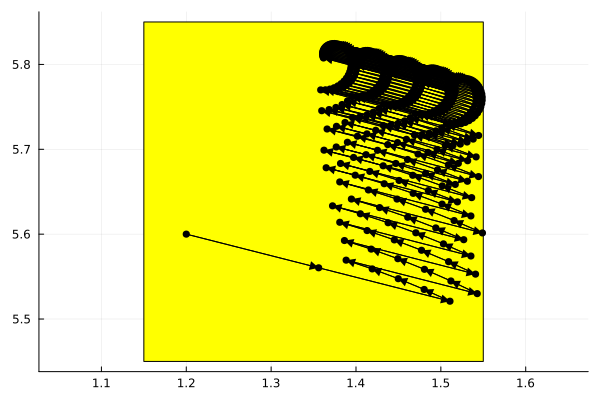

In [5]:
nstep = 300
x0 = SVector(1.2, 5.6)
x_traj, u_traj =
    CO.get_closed_loop_trajectory(concrete_system.f, concrete_controller, x0, nstep)

fig = plot(; aspect_ratio = :equal);
plot!(concrete_system.X);
plot!(UT.DrawTrajectory(x_traj))

### References
1. A. Girard, G. Pola and P. Tabuada, "Approximately Bisimilar Symbolic Models for Incrementally Stable Switched Systems," in IEEE Transactions on Automatic Control, vol. 55, no. 1, pp. 116-126, Jan. 2010.
2. S. Mouelhi, A. Girard, and G. Gössler. “CoSyMA: a tool for controller synthesis using multi-scale abstractions”. In: HSCC. ACM. 2013, pp. 83–88.
3. A. Girard. “Controller synthesis for safety and reachability via approximate bisimulation”. In: Automatica 48.5 (2012), pp. 947–953.
4. G. Reissig, A. Weber and M. Rungger, "Feedback Refinement Relations for the Synthesis of Symbolic Controllers," in IEEE Transactions on Automatic Control, vol. 62, no. 4, pp. 1781-1796.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*